In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !unzip '/content/drive/MyDrive/ddr/ddr.zip'

In [1]:
import keras
from keras import backend as K
import numpy as np
import glob
import tensorflow as tf
import shutil
from tensorflow.keras import regularizers

from keras import layers
from sklearn.model_selection import StratifiedKFold
from keras.layers import MaxPool2D,GlobalAveragePooling2D,Conv2D,Average,Reshape,Concatenate,Multiply,LayerNormalization,AveragePooling2D,GlobalMaxPool2D,Conv1D,BatchNormalization
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3 
# from keras.applications.inception_v2 import InceptionV2 
from keras.applications.densenet import DenseNet121
from keras.applications.vgg19 import VGG19
from keras.applications import ResNet50
from keras.layers.core import Lambda
from sklearn.metrics import roc_auc_score
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense,Reshape,Activation,Permute,Dot,Dropout,ReLU,Add
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
# from keras.utils import multi_gpu_model
from matplotlib import pyplot as plt
from keras.models import load_model
import os

2023-06-17 18:40:27.262101: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def Global_Attention_Block(inputs):
        shape=K.int_shape(inputs)
#         avg_pool=GlobalAveragePooling2D()(inputs)
        avg_pool=AveragePooling2D(pool_size=(shape[1],shape[2])) (inputs)
        avg_pool=Conv2D(shape[3],1,padding='same')(avg_pool)
        avg_pool=Activation('sigmoid')(avg_pool)
        avg_pool=Conv2D(shape[3],1,padding='same')(avg_pool)
        avg_pool=Activation('sigmoid')(avg_pool)
        
        C_A= Multiply()([inputs,avg_pool])
        avg_pool=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(C_A)
        avg_pool=Activation('sigmoid')(avg_pool)
        S_A= Multiply()([avg_pool,C_A])
        return S_A

In [3]:
def ChannelAttention(inputs,ratio):
    channels = inputs.shape[-1]
    l1=Dense(channels//ratio,activation='relu',use_bias=False)
    l2=Dense(channels,use_bias=False)


    avg_pool = GlobalAveragePooling2D()(inputs)
    avg_pool=l1(avg_pool)
    avg_pool=l2(avg_pool)

    max_pool=GlobalMaxPool2D()(inputs)
    max_pool=l1(max_pool)
    max_pool=l2(max_pool)

    fc2 =max_pool+avg_pool
    fc2 = Activation('sigmoid')(fc2)
    attention = Multiply()([inputs, fc2])
    return attention

In [4]:
def Category_Attention_Block(inputs,classes,k):
    shape=K.int_shape(inputs)
    F_1=Conv2D(k*classes,1,padding='same')(inputs)
    F_1=BatchNormalization()(F_1)
    F1=Activation('sigmoid')(F_1)
    
    F_2=F1
    x=GlobalMaxPool2D()(F_2)
    x=Reshape((classes,k)) (x)
    S=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))(x)
    
    x=Reshape((shape[1],shape[2],classes,k)) (F1)
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))(x)
    x=Multiply()([S,x])
    M=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(x)
    
    semantic=Multiply()([inputs,M])
    return semantic

In [5]:
def attention(inputs):
    shape=K.int_shape(inputs)
    x=AveragePooling2D(pool_size=(shape[1],shape[2])) (inputs)
    x=Conv2D(shape[3]//2,(1,1),padding='same') (x)
    x=Activation('relu') (x)
    x=Conv2D(shape[3],(1,1), padding='same') (x)
    x=Activation('sigmoid') (x)
    C_A=Multiply()([x,inputs])
    
    return C_A

In [6]:
def spatial_attention(inputs):
    shape=K.int_shape(inputs)
    x1=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(inputs)
    
    x1=Conv2D(shape[3],(1,1),padding='same')(x1)
    
    x1=Activation('sigmoid')(x1)
    
    x=Multiply()([x1,inputs])
    
    return x

In [7]:
def globalchannelattention(inputs):
    shape=K.int_shape(inputs)
    num_filters=shape[-1]
  
    initial=GlobalAveragePooling2D()(inputs)
    initial=Reshape((1,num_filters))(initial)

    a=Conv1D(num_filters,1,padding='same')(initial)
    a=Activation('sigmoid')(a)

    b=Conv1D(num_filters,1,padding='same')(initial)
    b=Activation('sigmoid')(b)

    b=K.permute_dimensions(b,(0,2,1))

    out=K.batch_dot(b,a,axes=(2,1))
    out=Activation('softmax')(out)

    c=Reshape((shape[1]*shape[2],num_filters))(inputs)

    final=K.batch_dot(c,out,axes=(2,1))

    final=Reshape((shape[1],shape[2],shape[3]))(final)

    return final

In [8]:
def SelfAttention(inputs,ratio):
   shape=K.int_shape(inputs)
   num_filters=shape[-1]
  #query
   x_q=Conv2D(shape[-1]//ratio,(3,3),padding='same')(inputs)
   x_q=Activation('sigmoid')(x_q)
   x_qnew=Reshape((shape[1]*shape[2],shape[3]//ratio))(x_q)

  #key
   x_k=Conv2D(shape[-1]//ratio,(1,1),padding='same')(inputs)
   x_k=Activation('sigmoid')(x_k)
   x_knew=Reshape((shape[1]*shape[2],shape[3]//ratio))(x_k)
  
   x_knew=K.permute_dimensions(x_knew,(0,2,1))
  #value
   x_v=Conv2D(shape[-1]//ratio,(1,1),padding='same')(inputs)
   x_v=Activation('softmax')(x_v)
   x_vnew=Reshape((shape[1]*shape[2],shape[3]//ratio))(x_v)


   x=K.batch_dot(x_qnew, x_knew,axes=(2,1))
   x1=Activation('softmax')(x)
    
   x2=K.batch_dot(x1, x_vnew,axes=(2,1))

   x_final=Reshape((shape[1],shape[2],shape[3]//ratio))(x2)

   x_final=Conv2D(shape[-1],(1,1),padding='same')(x_final)

   x_final=Activation('softmax')(x_final)

   x_final=Add()([x_final,inputs])

   return x_final

In [9]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points    

In [10]:
   
def plotmodel(history,name):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,smooth_curve(acc))
    plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_accuracy'], loc='upper left')
    plt.title(name)
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.title(name)
    plt.savefig('loss_'+name+'.png')

In [11]:
def get_base_model(model_name,img_size):
    if(model_name=='vgg19'):
        base_model=VGG19(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if model_name =='densenet121':
        base_model=DenseNet121(include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if(model_name=='inceptionv3'):
        base_model=InceptionV3(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if(model_name=='resnet50'):
        base_model=ResNet50(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if(model_name=='mobilenet'):
        base_model=MobileNet(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if(model_name=='mobilenet1.0'):
        base_model=MobileNet(include_top=False,weights='imagenet',alpha=1.0,input_shape=(img_size,img_size,3))
    if(model_name=='xception'):
        base_model=Xception(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    return base_model

In [12]:
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

def weighted_cross_entropy(alpha=0.62,beta=0.68):
    def loss_function(y_true, y_pred):
            
        weight = tf.where(tf.math.equal(y_true,1),alpha,1.0 - alpha)
        weight=tf.where(tf.math.equal(y_true,3),beta,weight)
#          weight = tf.where(tf.math.logical_or(tf.math.equal(y_true,3),tf.math.equal(y_true,1)),alpha,1.0 - alpha)
#         weight=tf.where(y_true==1,alpha,1.0-alpha)
        loss = CategoricalCrossentropy()(y_true, y_pred)
        weighted_loss = loss * weight
        return weighted_loss

    return loss_function


In [13]:
def spatial_hierarchical(last3,last2,last1,ratio):
    height3,width3,_ = last3.shape[1],last3.shape[2],last3.shape[3]
    
    height2,width2,_ = last2.shape[1],last2.shape[2],last2.shape[3]
    height1,width1,_ = last1.shape[1],last1.shape[2],last1.shape[3]

    num_filters=last3.shape[-1]//2

    input1=Conv2D(num_filters,(1,1),padding='same')(last3)  #h1xw1xc
    input2=Conv2D(num_filters,(1,1),padding='same')(last2)  #h2xw2xc
    input3=Conv2D(num_filters,(1,1),padding='same')(last1)  #h3xw3xc

    inp1=Reshape((height3*width3,num_filters))(input1) #h1w1xc

    inp2=Reshape((height2*width2,num_filters))(input2) #h2w2xc

    inp3=Reshape((height1*width1,num_filters))(input3) #h3w3xc
    

    k2=K.permute_dimensions(inp2,(0,2,1))  #cxh2w2

    x=K.batch_dot(inp1,k2,axes=(2,1)) #h1w1xh2w2

    x=Activation('softmax')(x)

    x1=K.batch_dot(x,inp1,axes=(2,1)) #h1w1xc

    k3=K.permute_dimensions(inp3,(0,2,1)) #cxh3w3

    x2=K.batch_dot(inp1,k3,axes=(2,1)) #h1w1xh3w3
    x2=Activation('softmax')(x2)
    
    x2=K.batch_dot(x2,inp1,axes=(2,1)) #h1w1xc

    
    x_final=Concatenate()([x1,x2,inp1])
    x_final=Reshape((height3,width3,x_final.shape[-1]))(x_final)
    x_final=Conv2D(last3.shape[-1],(1,1),padding='same')(x_final)
    x_final=Activation('softmax')(x_final)
    
   
    x_final=Add()([x_final,last3])
    

    return x_final


In [14]:
def point_att(inputs):
    shape=K.int_shape(inputs)
    
    x=Conv2D(shape[-1],(1,1),padding='same')(inputs)
    x=Activation('sigmoid')(x)
    
    x=Multiply()([x,inputs])
    
    return x

In [15]:
def new_model(last3,last2,last1):
#     shape = last3
    height,width,channels = last3.shape[1],last3.shape[2],last3.shape[3]
    input1=Reshape((height*width,last3.shape[-1]))(last3) #h1w1xc1

    input2=Reshape((height*width,last2.shape[-1]))(last2) #h1w1xc2

    input3=Reshape((height*width,last1.shape[-1]))(last1) #h1w1xc3

    k2=K.permute_dimensions(input2,(0,2,1)) # c2xh1w1

    x=K.batch_dot(k2,input1,axes=(2,1))  #c2xc1
    x=Activation('softmax')(x)

    x1=K.batch_dot(input1, x,axes=(2,1)) #h1w1xc1

    x1=Reshape((height,width,x1.shape[-1]))(x1) #h1xw1xc1

    k3=K.permute_dimensions(input3,(0,2,1)) # c3xh1w1
    
    x2=K.batch_dot(k3,input1,axes=(2,1)) #c3xc1
    x2=Activation('softmax')(x2)

    x2=K.batch_dot(input1,x2,axes=(2,1)) #h1w1xc1

    x2=Reshape((height,width,x2.shape[-1]))(x2) #h1xw1xc1
    
    x_final=Concatenate()([x1,x2,last3])
   
    x_final=Conv2D(channels,(1,1),padding='same')(x_final)
    x_final=Activation('softmax')(x_final)
  

    return x_final

In [16]:
def GSAM(inputs,channel_inp):
    shape=K.int_shape(inputs)
    x1=AveragePooling2D(pool_size=(shape[1],shape[2]))(inputs)
    x2=MaxPool2D(pool_size=(shape[1],shape[2]))(inputs)
    
    x3=AveragePooling2D(pool_size=(shape[1],shape[2]))(channel_inp)
    x4=MaxPool2D(pool_size=(shape[1],shape[2]))(channel_inp)
    
    x1=Add()([x1,x3])
    x1=Activation('sigmoid')(x1)
    
    x2=Add()([x2,x4])
    x2=Activation('sigmoid')(x2)
    
    x_final=Concatenate()([x2,x1])
    
    x_final=Conv2D(shape[-1],(1,1),padding='same')(x_final)
    x_final=Activation('sigmoid')(x_final)
    
    x_final=Multiply()([x_final,channel_inp])
    
    return x_final
    

In [17]:
constraint=tf.keras.constraints.min_max_norm(max_value=1,min_value=0)

In [18]:
class WeightedSum(layers.Layer):

    def __init__(self, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)

    def build(self, input_shape=1):
        self.a = self.add_weight( name='alpha',shape=( 1, 1, 1),initializer='random_normal',dtype='float32',trainable=True,
            constraint = constraint,)
        self.b = self.add_weight(name='beta',shape=( 1, 1, 1),initializer='random_normal',dtype='float32',trainable=True,constraint = constraint,)
        
#         self.c = self.add_weight(name='gamma',shape=( 1, 1, 1),initializer='random_normal',dtype='float32',trainable=True,constraint = constraint,)
        super(WeightedSum, self).build(input_shape)

    def call(self, model_outputs):
#         return tf.multiply(model_outputs[0],self.a) + tf.multiply(model_outputs[1], self.b) + tf.multiply(model_outputs[2], self.c)
        return tf.multiply(model_outputs[0],self.a) + tf.multiply(model_outputs[1], self.b) 


In [19]:
def rotateToAttend(input_feature):
  shape = K.int_shape(input_feature)
  # HxwxC
  permute_1 =tf.keras.layers.Permute((3,2,1),input_shape=(shape[1],shape[2],shape[3]))(input_feature) 
  #  cxwxh
  x1 = Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(permute_1)
  x2 = Lambda(lambda x: K.max(x,axis=-1,keepdims=True))(permute_1)
  x3 = tf.keras.layers.Concatenate(axis=-1)([x1, x2])
  x = Conv2D(1,1, padding='same', dilation_rate=(1, 1)) (x1)
  x = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.01)(x)
  x = tf.keras.activations.sigmoid(x)  
  x = tf.keras.layers.Multiply()([x,permute_1])
  F1 = tf.keras.layers.Permute((3,2,1),input_shape=(shape[1],shape[2],shape[3]))(x)

  permute_2 = tf.keras.layers.Permute((1,3,2),input_shape=(shape[1],shape[2],shape[3]))(input_feature)
  x1 = Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(permute_2)
  x2 = Lambda(lambda x: K.max(x,axis=-1,keepdims=True))(permute_2)
  x3 = tf.keras.layers.Concatenate(axis=-1)([x1, x2])
  x = Conv2D(1,1, padding='same', dilation_rate=(1, 1)) (x1)
  x = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.01)(x)
  x = tf.keras.activations.sigmoid(x)  
  x = tf.keras.layers.Multiply()([x,permute_2])
  F2 = tf.keras.layers.Permute((1,3,2),input_shape=(shape[1],shape[2],shape[3]))(x)


  permute_3 = input_feature
  x1 = Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(permute_3)
  x2 = Lambda(lambda x: K.max(x,axis=-1,keepdims=True))(permute_3)
  x3 = tf.keras.layers.Concatenate(axis=-1)([x1, x2])
  x = Conv2D(1,1, padding='same', dilation_rate=(1, 1)) (x1)
  x = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.01)(x)
  x = tf.keras.activations.sigmoid(x)  
  F3 = tf.keras.layers.Multiply()([x,permute_3])

  attend_feature = tf.keras.layers.Average()([F1, F2, F3])
  return attend_feature

In [20]:
def train_model(model,image_size,batch_size,save_name,lr1,lr2,Epochs1,Epochs2):

    train_dir_fold='/home/dipankar/dipankar/tushir/ddr/train'
    val_dir_fold='/home/dipankar/dipankar/tushir/ddr/validation'

    train_num,valid_num=6260,2503 

    train=ImageDataGenerator(rescale=1./255,horizontal_flip=True,vertical_flip=True,rotation_range=90)     

    valid = ImageDataGenerator(rescale=1./255)
      
    train_data = train.flow_from_directory(train_dir_fold, target_size=(image_size, image_size),shuffle=True,
                                                  batch_size=batch_size)
    val_data = valid.flow_from_directory(val_dir_fold, target_size=(image_size, image_size),shuffle=False,
                                                 batch_size=batch_size)
                                                  
      
    
    
    
    lr_decay=ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1)
    save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',save_best_only=True,mode='min')
    
    for layer in base_model.layers:
         layer.trainable=False

    model.compile(optimizer=Adam(learning_rate=lr1,decay=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_data,steps_per_epoch=train_num/batch_size,validation_data=val_data,validation_steps=valid_num/batch_size,
              epochs=Epochs1,workers=2,callbacks=[lr_decay,save_model])
     
    for layer in base_model.layers:
         layer.trainable = True
        
    model.compile(optimizer=Adam(learning_rate=lr2,decay=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])
    history=model.fit(train_data,steps_per_epoch=train_num/batch_size,validation_data=val_data,
                      validation_steps=valid_num/batch_size,epochs=Epochs2,workers=2,
                       callbacks=[lr_decay,save_model])

    return history

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Dense

k = 5
lr1 = 0.005
lr2 = 0.0001
batch_size = 12
image_size = 512
classes = 5


base_model=ResNet50(include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
base_in = base_model.input
base_out=base_model.output


last3 = base_model.get_layer('conv5_block3_out').output
last2 = base_model.get_layer('conv5_block2_out').output
last1 = base_model.get_layer('conv5_block1_out').output


# last3=Conv2D(base_out.shape[-1],(1,1),padding='same')(last3)
# last2=Conv2D(base_out.shape[-1]//2,(1,1),padding='same')(last2)
# last1=Conv2D(base_out.shape[-1]//2,(1,1),padding='same')(last1)

# x=Concatenate()([last3,last2,last1])


# x1 = globalchannelattention(base_out)
x1 = spatial_hierarchical(last3,last2,last1,2)
x2 = new_model(last3,last2,last1)
# x = globalchannelattention(compress)
# x2 = SelfAttention(compress, 2)

# x2=spatial_attention(base_out)


# x1=rotateToAttend(base_out)
# x2=point_att(base_out)
# x3=attention(base_out)

# x=Add()([x1,x2,x3])
# x=WeightedSum()([x1,x2,x3])

x=Concatenate()([x1,x2])

# x=Add()([last3,x1])

# x=Multiply()([x1,last3])
# x=WeightedSum()([last3,x])


x = GlobalAveragePooling2D()(x)
out = Dense(classes, activation='softmax')(x)

parallel_model = Model(base_in, out)
parallel_model.summary()


2023-06-17 18:40:29.878996: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-17 18:40:29.880447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-17 18:40:29.992946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-06-17 18:40:29.993788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-06-17 18:40:29.993820: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
history=train_model(parallel_model,image_size,batch_size,'resnet_global_channel',lr1,lr2,1,50)

Found 6260 images belonging to 5 classes.
Found 2503 images belonging to 5 classes.


2023-06-17 18:40:41.505078: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-17 18:40:41.526515: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2023-06-17 18:40:44.766304: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-17 18:40:45.778549: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-17 18:40:47.096658: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-06-17 18:40:47.217383: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


115/521 [=====>........................] - ETA: 2:58 - loss: 1.7553 - accuracy: 0.4454

In [ ]:
plotmodel(history,'resnet_global_channel')

In [29]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score

loss_function=weighted_cross_entropy()
# keras.utils.register_keras_serializable('loss_function')(loss_function)

with keras.utils.custom_object_scope({'loss_function':loss_function}):
         model_name='/home/dipankar/dipankar/tushir/new/resnet_global_channel10_(78.29).h5'
         model = load_model(model_name)

test_dir = '/home/dipankar/dipankar/tushir/ddr/test/' 
batch_size = 12
image_size=512
test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    shuffle=False,
    batch_size=batch_size)

loss, accuracy = model.evaluate(test_data)

print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')



Found 3759 images belonging to 5 classes.
314/314 [==============================] - 88s 277ms/step - loss: 0.6347 - accuracy: 0.7829
Test Loss: 0.6346911787986755, Test Accuracy: 0.7829210162162781


[[1802    9   68    0    1]
 [  73   17   99    0    0]
 [ 320   50  962    5    7]
 [   1    0   44   22    4]
 [  18    1  107    9  140]]


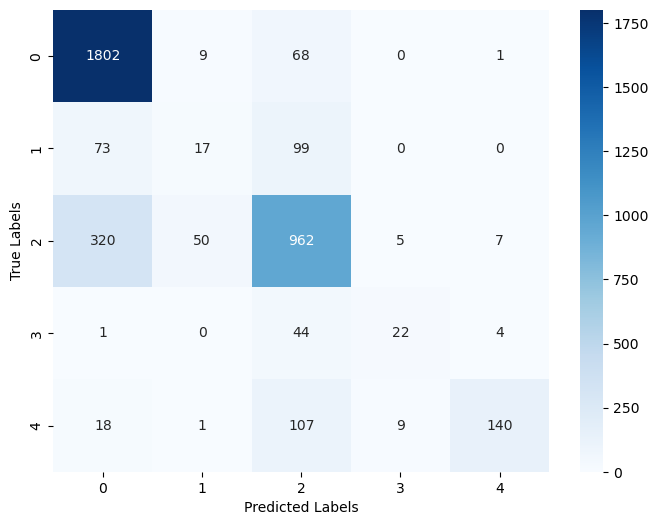

In [27]:
import seaborn as sns
y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print(confusion_mtx)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_mtx,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score

f=f1_score(y_true,y_pred_classes,average='weighted')
roc=roc_auc_score(y_true,y_pred,average='weighted',multi_class='ovo')
print(f)
print(roc)

0.76460048600986
0.8800220651711166


In [ ]:
def weight_kappa(result,test_num):
    weight=np.zeros((5,5),dtype='float')
    for i in range(5):
        for j in range(5):
            weight[i,j]=(i-j)*(i-j)/16
    fenzi=0
    for i in range(5):
        for j in range(5):
            fenzi=fenzi+result[i,j]*weight[i,j]
    fenmu=0
    for i in range(5):
        for j in range(5):
            fenmu=fenmu+weight[i,j]*result[:,j].sum()*result[i,:].sum()

    weght_kappa=1-(fenzi/(fenmu/test_num))
    return  weght_kappa


test_num=0
result=np.zeros((5,5),dtype=int)
recall=np.zeros((1,5),dtype=float)
for i in range(5):
        datadirs=test_dir+str(i)+'/'
        filenames=os.listdir(datadirs)
        num=len(filenames)
        test_num=test_num+num
        valid = ImageDataGenerator(rescale=1./255)
        valid_data=valid.flow_from_directory(directory=test_dir,target_size=(image_size,image_size),
                                             batch_size=batch_size,class_mode=None,classes=str(i))
        predict=model.predict_generator(valid_data,steps=num/batch_size,verbose=1,workers=1)
        predict=np.argmax(predict,axis=-1)
        for j in range(5):
            result[i,j]=np.sum(predict==j)

# right=result[0,0]+result[1,1]+result[2,2]+result[3,3]+result[4,4]
# print('Acc:',right/test_num)

w_kappa=weight_kappa(result,test_num)
print('w_kappa:',w_kappa)

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def grad_cam(model, image_path, layer_name, class_index, image_size):
    img = image.load_img(image_path, target_size=(image_size, image_size))
    img_orig = img.copy()
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, class_index]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, (image_size, image_size))
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    img_orig = np.array(img_orig) 
    overlaid_img = cv2.addWeighted(img_orig, 0.7, heatmap, 0.3, 0)

    return overlaid_img


image_path = '/home/dipankar/dipankar/tushir/ddr/train/3/007-2766-100.jpg'  
layer_name = 'reshape_2'  
class_index =4

image_size = 512 

overlaid_img  = grad_cam(parallel_model, image_path, layer_name, class_index, image_size)
original_img = image.load_img(image_path, target_size=(image_size, image_size))
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original_img)
axs[0].axis('off')
axs[0].set_title('Original Image')
axs[1].imshow(overlaid_img)
axs[1].axis('off')
axs[1].set_title('Overlaid Image with Heatmap')
plt.show()
